# 18장. 시퀀스 배열로 다루는 순환신경망(RNN)

* 인공지능이 문장을 듣고 이해한다는 것은 많은 문장을 이미 학습해놓았다는 것. 
* 문장을 학습하는 것은 지금까지와 성질이 조금 다른데, 문장은 여러 개의 단어로 이루어져 있고 그 의미를 전달하려면 각 단어가 ***순서대로*** 입력되어야하기 때문.
* 즉, 여러 데이터가 순서에 관계없이 입력되던 것과 다르게, 이번에는 **과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계**를 고려해야하는 문제가 생김. 
<br>
<br>
#### 순환신경망(RNN)
* 순환신경망은 여러 개의 데이터가 순서대로 입력되었을 때 앞서 입력받은 데이터를 잠시 기억해 놓는 방법
* 기억된 데이터가 얼마나 중요한지 판단하고 별도의 가중치를 주어 다음 데이터로 넘어감.
* 모든 입력 값에 이 작업을 순서대로 실행하므로 다음 층으로 넘어가기 전에 같은 층을 맴도는 것처럼 보인다.
* 이렇게 같은 층 안에서 맴도는 성질 때문에 순환신경망(RNN)이라 한다.

* 그림 18-1의 순환신경망(RNN)에 해당하는 '순환' 부분에서는 단어를 하나 처리할 때마다 기억해 다음 입력 값의 출력을 결정(그림 18-2) <br>
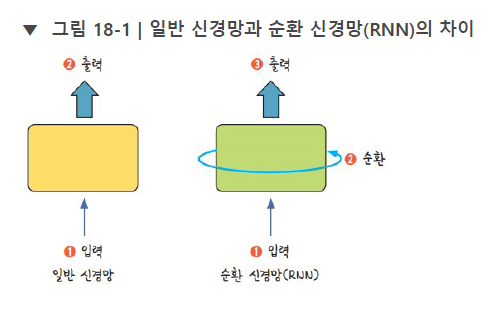
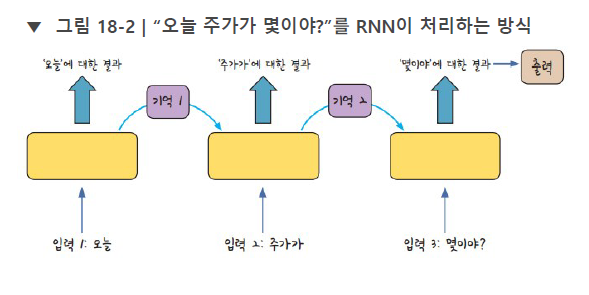

* 순환되는 중에 앞서 나온 입력에 대한 결과가 뒤에 나오는 입력 값에 영향을 준다. 
* 비슷한 두 문장이 입력되었을 때 그차이를 구별해 출력값에 반영

#### LSTM
* LSTM은 한 층안에서 반복을 많이 해야하는 RNN의 특성상 일반 신경망보다 기울기 소실 문제가 더 많이 발생하고 이를 해결하기 어렵다는 단점을 보완한 방법
* 즉, 반복되기 직전에 다음 층으로 기억된 값을 넘길지 여부를 관리하는 단계를 하나 더 추가하는 것. 

### 1. LSTM(Long Short Tem Memory)을 이용한 로이터 뉴스 카테고리 분류하기

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)        # 빈도가 1~1000인 것만 가져온다. 

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [17]:
print(X_train[3])       # 3번째 기사의 단어 빈도수
print(y_train[3])       # 3번째 기사의 카테고리가 4번

[1, 4, 686, 867, 558, 4, 37, 38, 309, 2, 465, 893, 2, 114, 2, 69, 312, 35, 15, 7, 335, 2, 21, 25, 2, 2, 2, 58, 69, 68, 493, 5, 25, 465, 377, 2, 4, 293, 2, 739, 2, 8, 7, 2, 2, 13, 899, 6, 4, 990, 309, 415, 2, 2, 645, 2, 791, 5, 2, 75, 8, 24, 10, 2, 2, 5, 344, 756, 7, 2, 231, 2, 2, 2, 43, 509, 43, 68, 327, 5, 2, 2, 297, 638, 73, 430, 22, 4, 580, 7, 48, 41, 30, 2, 136, 4, 344, 298, 4, 580, 40, 344, 2, 2, 291, 2, 10, 2, 5, 231, 2, 2, 5, 2, 2, 21, 2, 2, 990, 309, 415, 265, 2, 2, 2, 2, 2, 4, 344, 2, 756, 2, 2, 2, 2, 2, 28, 10, 2, 24, 77, 41, 682, 10, 2, 2, 7, 4, 2, 2, 2, 22, 370, 2, 2, 5, 54, 2, 2, 2, 10, 2, 946, 60, 51, 2, 2, 4, 73, 2, 669, 4, 580, 64, 10, 2, 6, 2, 25, 482, 35, 150, 377, 2, 7, 10, 2, 836, 2, 2, 2, 5, 2, 2, 2, 2, 8, 4, 344, 291, 2, 298, 2, 6, 2, 24, 2, 41, 343, 430, 210, 6, 2, 297, 64, 10, 2, 455, 5, 2, 125, 222, 17, 12]
4


#### 1) 훈련용 뉴스 데이터의 기사 길이 확인

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


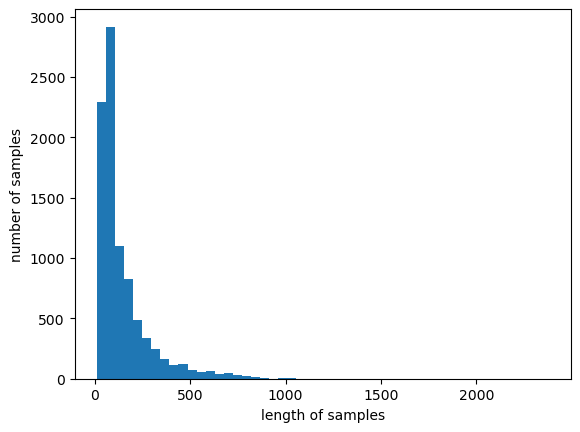

In [18]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 2) 각 뉴스의 레이블 값의 분포를 확인하고 각 레이블에 대한 정확한 개수를 출력

In [19]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


####  3) 정수 인코딩된 각 숫자들이 어떤 단어들을 나타내고 있는지 확인

In [20]:
word_to_index = reuters.get_word_index()
print(word_to_index)

{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, 'errors': 7247, 'deferred': 3086, 'sptnd': 20683, 'cooking': 8805, 'stratabit': 20684, 'designing': 16262, 'metalurgicos': 20685, 'databank': 13798, '300er': 20686, 'shocks': 20687, 'nawg': 7972, 'tnta': 20688, 'perforations': 20689, 'affiliates': 2891, '27p': 20690, 'ching': 16263, 'china': 595, 'wagyu': 16264, 'affiliated': 3189, 'chino': 16265, 'chinh': 16266, 'slickline': 20692, 'doldrums': 13799, 'kids': 12092, 'cl

In [21]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 100등 단어 : {}'.format(index_to_word[103]))

빈도수 상위 1번 단어 : the
빈도수 상위 100등 단어 : group


* 숫자 0: 패딩
* 숫자1: 문장의 시작을 의미. sos(기호)
* 숫자2: OoV(Out of Vocabulary). unk(기호)       

In [22]:
for index, token in enumerate(("", "", "")):
      index_to_word[index] = token
print(' '.join([index_to_word[index] for index in X_train[0]]))

   said as a result of its december acquisition of  co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and   revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash  per share this year should be 2 50 to three dlrs reuter 3


In [15]:
# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 48s 100ms/step - loss: 2.1611 - accuracy: 0.4499 - val_loss: 2.0183 - val_accuracy: 0.4907
Epoch 2/200
450/450 [==============================] - 43s 95ms/step - loss: 1.8082 - accuracy: 0.5399 - val_loss: 1.7131 - val_accuracy: 0.5641
Epoch 3/200
450/450 [==============================] - 39s 86ms/step - loss: 1.6446 - accuracy: 0.5745 - val_loss: 1.6931 - val_accuracy: 0.5548
Epoch 4/200
450/450 [==============================] - 45s 101ms/step - loss: 1.5671 - accuracy: 0.5941 - val_loss: 1.5699 - val_accuracy: 0.6042
Epoch 5/200
450/450 [==============================] - 38s 84ms/step - loss: 1.3842 - accuracy: 0.6532 - val_loss: 1.3886 - val_accuracy: 0.6621
Epoch 6/200
450/450 [==============================] - 41s 91ms/step - loss: 1.2362 - accuracy: 0.6932 - val_loss: 1.3379 - val_accuracy: 0.6594
Epoch 7/200
450/450 [==============================] - 41s 91ms/step - loss: 1.1326 - accuracy: 0.7103 - val_loss: 1.2256 - val_

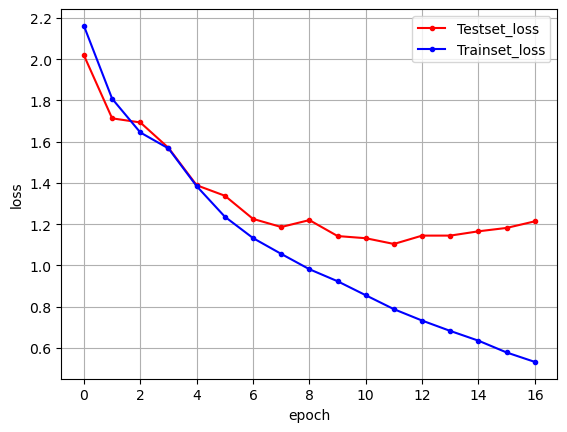

In [23]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

17464789/17464789 [==============================] - 2s 0us/step


In [25]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [26]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


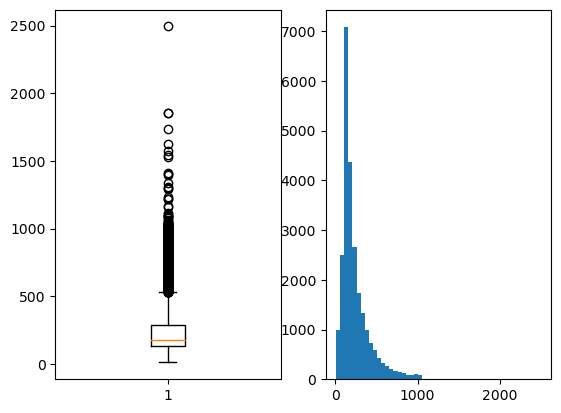

In [27]:
len_result = [len(s) for s in X_train]
print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))
plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [28]:
# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))          # strides =1 움직일 때 한 칸씩 움직암.
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 55)                26400     
                                                                 
 dense_4 (Dense)             (None, 1)                 56        
                                                      

In [29]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 99s 201ms/step - loss: 0.4118 - accuracy: 0.7951 - val_loss: 0.2861 - val_accuracy: 0.8786
Epoch 2/100
469/469 [==============================] - 89s 190ms/step - loss: 0.2332 - accuracy: 0.9089 - val_loss: 0.2716 - val_accuracy: 0.8882
Epoch 3/100
469/469 [==============================] - 82s 176ms/step - loss: 0.1840 - accuracy: 0.9319 - val_loss: 0.3099 - val_accuracy: 0.8763
Epoch 4/100
469/469 [==============================] - 93s 198ms/step - loss: 0.1453 - accuracy: 0.9465 - val_loss: 0.2744 - val_accuracy: 0.8877
Epoch 5/100
782/782 [==============================] - 31s 40ms/step - loss: 0.3204 - accuracy: 0.8802

 Test Accuracy: 0.8802


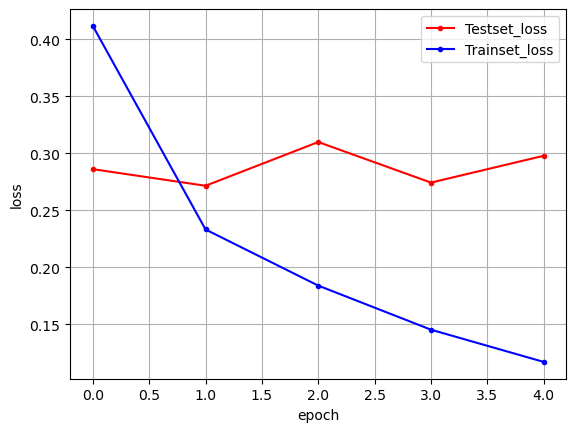

In [31]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 3. 어텐션을 사용한 신경망

In [30]:
!pip install attention

* '당신께'는 어텐션 가중치 4, '필요한'은 어텐션 가중치 5, '전부는'은 가중치 3, '어텐션'은 1, '이네요!'는 가중치 2

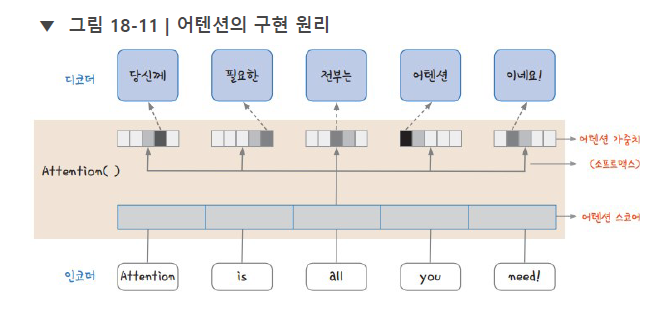

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다. 
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - 974s 2s/step - loss: 0.3736 - accuracy: 0.8292 - val_loss: 0.2867 - val_accuracy: 0.8850
Epoch 2/100
625/625 [==============================] - 1028s 2s/step - loss: 0.2228 - accuracy: 0.9105 - val_loss: 0.2623 - val_accuracy: 0.8937
Epoch 3/100
625/625 [==============================] - 1005s 2s/step - loss: 0.1611 - accuracy: 0.9371 - val_loss: 0.2923 - val_accuracy: 0.8888
Epoch 4/100
625/625 [==============================] - 867s 1s/step - loss: 0.1152 - accuracy: 0.9556 - val_loss: 0.3468 - val_accuracy: 0.8774
Epoch 5/100
782/782 [==============================] - 194s 247ms/step - loss: 0.4086 - accuracy: 0.8803

 Test Accuracy: 0.8803


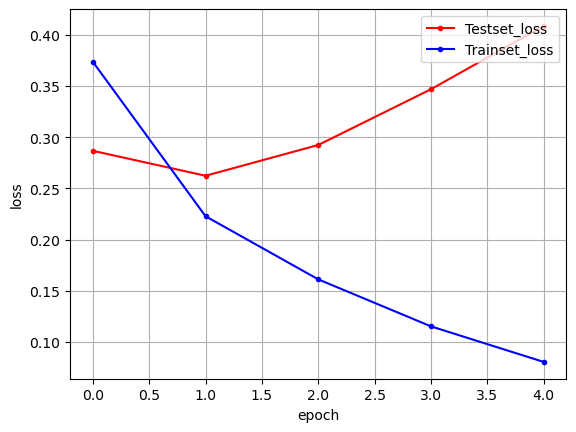

In [33]:
# 학습셋과 테스트셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()